In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.10.0+cu111
Torchvision Version:  0.11.1+cu111


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
# Takes in a pretrained model passed through additional FC layers and concatenates this to feature embeddings
# of the metadata passed through FC layers

class PawModel(nn.Module):
    def __init__(self, pretrained_model):
        super(PawModel, self).__init__()
        
        # Call the pretrained model and add FC layer
        self.pretrained_model = pretrained_model
#         self.added_layers = nn.Linear(1024, 512)
        
#         # Pass the metadata through FC layers
#         self.meta_layers = nn.Sequential(nn.Linear(12, 24),
#                                          nn.Linear(24, 48),
#                                          nn.Linear(48, 96))
        
#         # Pass the concatenated embeddings through additional FC layers
#         self.final_layers = nn.Sequential(nn.Linear(608, 120),
#                                          nn.Linear(120, 1),
#                                          nn.ReLU())
        self.added_layers = nn.Linear(1024, 1024)
        
        # Pass the metadata through FC layers
        self.meta_layers = nn.Sequential(nn.Linear(12, 128),
                                         nn.Linear(128, 256),
                                         nn.Linear(256, 512),
                                         nn.Linear(512, 1024))
        
        # Pass the concatenated embeddings through additional FC layers
        self.final_layers = nn.Sequential(nn.Linear(2048, 1024),
                                          nn.Dropout(0.2),
                                          nn.Linear(1024, 512),
                                          nn.Dropout(0.2),
                                          nn.Linear(512, 1),
                                          nn.ReLU())
    
    def forward(self, img, meta):
        # Process the image data
        img_layer = self.pretrained_model(img)
        img_layer = self.added_layers(img_layer)
        
        # Process the meta data
        meta_layer = self.meta_layers(meta)
        
        # Concatenate the image and meta data embeddings and pass through final layers
        final_layer = torch.cat([img_layer, meta_layer], axis = 1)
        final_layer = self.final_layers(final_layer)
        
        return final_layer 

In [ ]:
paw_model = torch.load(('best_densenet.pth'), map_location=torch.device('cpu'))
paw_model.eval()

#DRISE

In [ ]:
def generate_mask(image_size, grid_size, prob_thresh):
    image_w, image_h = image_size
    grid_w, grid_h = grid_size
    cell_w, cell_h = math.ceil(image_w / grid_w), math.ceil(image_h / grid_h)
    up_w, up_h = (grid_w + 1) * cell_w, (grid_h + 1) * cell_h
    

    mask = (np.random.uniform(0, 1, size=(grid_h, grid_w)) <
            prob_thresh).astype(np.float32)
    
    mask = cv2.resize(mask, (up_w, up_h), interpolation=cv2.INTER_LINEAR)
    offset_w = np.random.randint(0, cell_w)
    offset_h = np.random.randint(0, cell_h)
    mask = mask[offset_h:offset_h + image_h, offset_w:offset_w + image_w]
    mask =np.dstack([mask] * 3)
    mask = torch.permute(torch.tensor(mask),(2,0,1))
    mask = mask[None,:]
    #
    return mask

In [ ]:
avg_score = np.array(['878dbfd022bfd06342c024374fc7a777','5c04855bfa7235f492779986c4fab66c', 'aeae0fc4cd5623efa8d6d2ba422bf6b2', 'df5a9f783ff2ae373ee99fa33679da64'])
low_scores = np.array(['1f55470bdc1f60f6681c9e97868f97ca', 'a8a859fb8dd237e455e93f4bc2d3918a',  'd5f8af19eb62b4b0f0363647c43ba733',  'fb883d38c9f21c49e7b832964d881084'])
high_scores  = np.array(['d0fa3096b3b048f477137f439a7014a7',       'ef7f96e35710c26e81f67ed29e967193',       '3afe7c6e9ed321e3219e8d45c1192773',       'd0b367aa832b8fa6d708cad5d7f41059'])


In [ ]:
import pandas as pd
import cv2
import math
from google.colab.patches import cv2_imshow

Single Sample 

(853, 1280, 3)
31


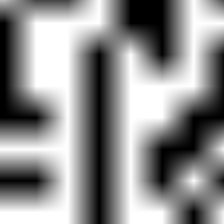

torch.Size([1, 3, 224, 224])


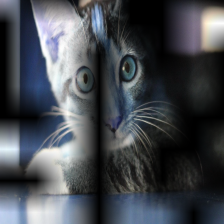

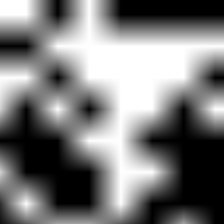

torch.Size([1, 3, 224, 224])


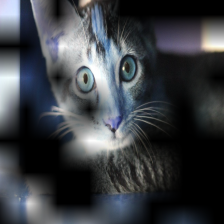

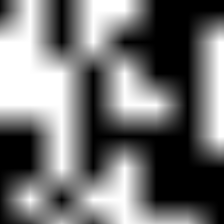

torch.Size([1, 3, 224, 224])


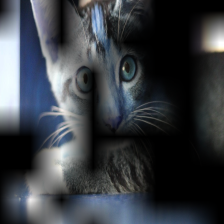

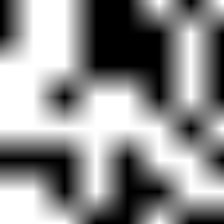

torch.Size([1, 3, 224, 224])


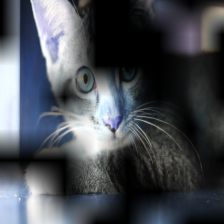

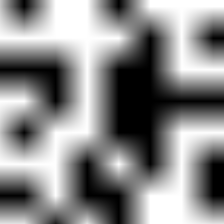

torch.Size([1, 3, 224, 224])


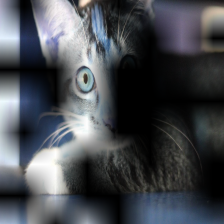

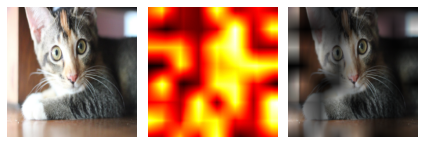

In [ ]:

name = 'ffaf7bf7e64b9eecaf02fc2c14d6b654'
resol= 224
for i in range(1):
    filepath ='/content/ffaf7bf7e64b9eecaf02fc2c14d6b654.jpg'
    train_img = cv2.imread(filepath)
    print(train_img.shape)

    train_img = cv2.cvtColor(train_img, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(train_img, (resol, resol), interpolation = cv2.INTER_AREA)  
    image_resized = torch.permute(torch.tensor(image_resized),(2,0,1)).float()/255
    data = pd.read_csv("/content/drive/MyDrive/petfinder-pawpularity-score/train.csv")
    meta = torch.tensor(np.array((data[data["Id"]==name].iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12]])))
    meta = meta.float()  
    image_resized = image_resized[None,:].float()
    pop =np.array( data[data["Id"]==name].iloc[:,[13]])[0][0]
    print(pop)
    res = torch.zeros((1,3,224,224))
    for k in range(5):
          mask = generate_mask(image_size=(224,224), grid_size=(8,8),prob_thresh=0.5)
          cv2_imshow(mask[0].detach().numpy().transpose(1, 2, 0)*255)
          masked = mask*image_resized
          print(masked.shape)
          cv2_imshow(masked[0].detach().numpy().transpose(1, 2, 0)*255)
          out = paw_model(masked,meta)
          score = (out-pop)**2/100
          res+=(mask*score)
          
    res[0][0] = (res[0][0]-res[0][0].min())/(res[0][0].max()-res[0][0].min())
    res[0][1] = (res[0][1]-res[0][1].min())/(res[0][1].max()-res[0][1].min())
    res[0][2] = (res[0][2]-res[0][2].min())/(res[0][2].max()-res[0][2].min())
    res = 1-res

    res_overlap = res[0]*image_resized
    #plt.imshow((res[0]*image_resized[0]).permute(1, 2, 0).detach().numpy())
    savename = '/content/drive/MyDrive/petfinder-pawpularity-score/train/' +  str(pop) + str(name) + '.jpg' 
    #plt.savefig(res,savename)
    fig, ax = plt.subplots(1, 3)

    ax[0].imshow(image_resized[0].cpu().detach().numpy().transpose(1, 2, 0))
    ax[0].axis('off')
    ax[1].imshow(res[0][0].cpu().detach().numpy(), cmap='hot')
    ax[1].axis('off')
    ax[2].imshow(res_overlap[0].cpu().detach().numpy().transpose(1, 2, 0), cmap='hot')
    ax[2].axis('off')

    plt.tight_layout()
    #fig.suptitle('The Image and Its Saliency Map')
    
    fig.savefig('/content/drive/MyDrive/petfinder-pawpularity-score/train/SaliencyMap/' + str(int(pop))+'_'+ str(name) + '.jpg' )




In [ ]:
resol= 224

for i,name in enumerate(high_scores):
  if i ==0 :
    pass
  else:
    print(i)
    filepath = '/content/drive/MyDrive/petfinder-pawpularity-score/train/' + name + '.jpg'
    train_img = cv2.imread(filepath)
    print(train_img.shape)
    train_img = cv2.cvtColor(train_img, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(train_img, (resol, resol), interpolation = cv2.INTER_AREA)  
    image_resized = torch.permute(torch.tensor(image_resized),(2,0,1)).float()/255
    data = pd.read_csv("/content/drive/MyDrive/petfinder-pawpularity-score/train.csv")
    meta = torch.tensor(np.array((data[data["Id"]==name].iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12]])))
    meta = meta.float()  
    image_resized = image_resized[None,:].float()
    pop = paw_model(torch.tensor(image_resized),meta)
    res = torch.zeros((1,3,224,224))
    for k in range(500):
          mask = generate_mask(image_size=(224,224), grid_size=(8,8),prob_thresh=0.5)
          masked = mask*image_resized
          out = paw_model(masked,meta)
          score = (out-pop)**2/100
          res+=(mask*score)
          
    res[0][0] = (res[0][0]-res[0][0].min())/(res[0][0].max()-res[0][0].min())
    res[0][1] = (res[0][1]-res[0][1].min())/(res[0][1].max()-res[0][1].min())
    res[0][2] = (res[0][2]-res[0][2].min())/(res[0][2].max()-res[0][2].min())
    res = 1-res

    res_overlap = res[0]*image_resized
    #plt.imshow((res[0]*image_resized[0]).permute(1, 2, 0).detach().numpy())
    savename = '/content/drive/MyDrive/petfinder-pawpularity-score/train/' +  str(pop) + str(name) + '.jpg' 
    #plt.savefig(res,savename)
    fig, ax = plt.subplots(1, 3)

    ax[0].imshow(image_resized[0].cpu().detach().numpy().transpose(1, 2, 0))
    ax[0].axis('off')
    ax[1].imshow(res[0][0].cpu().detach().numpy(), cmap='hot')
    ax[1].axis('off')
    ax[2].imshow(res_overlap[0].cpu().detach().numpy().transpose(1, 2, 0), cmap='hot')
    ax[2].axis('off')

    plt.tight_layout()
    #fig.suptitle('The Image and Its Saliency Map')
    
    fig.savefig('/content/drive/MyDrive/petfinder-pawpularity-score/train/SaliencyMap/' + str(int(pop))+'_'+ str(name) + '.jpg' )




1
(960, 540, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


2
(951, 607, 3)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
resol= 8
for i,name in enumerate(high_scores):

    print(i)
    filepath = '/content/drive/MyDrive/petfinder-pawpularity-score/train/' + name + '.jpg'
    train_img = cv2.imread(filepath)
    train_img = cv2.cvtColor(train_img, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(train_img, (resol, resol), interpolation = cv2.INTER_AREA)  
    image_resized = torch.permute(torch.tensor(image_resized),(2,0,1)).float()/255
    data = pd.read_csv("/content/drive/MyDrive/petfinder-pawpularity-score/train.csv")
    meta = torch.tensor(np.array((data[data["Id"]==name].iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12]])))
    meta = meta.float()  
    image_resized = image_resized[None,:].float()
    pop = paw_model(torch.tensor(image_resized),meta)
    res = torch.zeros((1,3,224,224))
    for k in range(5):
          mask = generate_mask(image_size=(224,224), grid_size=(8,8),prob_thresh=0.5)
          masked = mask*image_resized
          cv2_imshow(masked)
          out = paw_model(masked,meta)
          score = (out-pop)**2/100
          res+=(mask*score)
          
    res[0][0] = (res[0][0]-res[0][0].min())/(res[0][0].max()-res[0][0].min())
    res[0][1] = (res[0][1]-res[0][1].min())/(res[0][1].max()-res[0][1].min())
    res[0][2] = (res[0][2]-res[0][2].min())/(res[0][2].max()-res[0][2].min())
    res = 1-res

    res_overlap = res[0]*image_resized
    #plt.imshow((res[0]*image_resized[0]).permute(1, 2, 0).detach().numpy())
    savename = '/content/drive/MyDrive/petfinder-pawpularity-score/train/' +  str(pop) + str(name) + '.jpg' 
    #plt.savefig(res,savename)
    fig, ax = plt.subplots(1, 3)

    ax[0].imshow(image_resized[0].cpu().detach().numpy().transpose(1, 2, 0))
    ax[0].axis('off')
    ax[1].imshow(res[0][0].cpu().detach().numpy(), cmap='hot')
    ax[1].axis('off')
    ax[2].imshow(res_overlap[0].cpu().detach().numpy().transpose(1, 2, 0), cmap='hot')
    ax[2].axis('off')

    plt.tight_layout()
    #fig.suptitle('The Image and Its Saliency Map')
    
    fig.savefig('/content/drive/MyDrive/petfinder-pawpularity-score/train/SaliencyMap/' + str(int(pop))+ str(name) + '.jpg' )
  






  

In [ ]:

for i,name in enumerate(avg_scores):

    print(i)
    filepath = '/content/drive/MyDrive/petfinder-pawpularity-score/train/' + name + '.jpg'
    train_img = cv2.imread(filepath)
    train_img = cv2.cvtColor(train_img, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(train_img, (resol, resol), interpolation = cv2.INTER_AREA)  
    image_resized = torch.permute(torch.tensor(image_resized),(2,0,1)).float()/255
    data = pd.read_csv("/content/drive/MyDrive/petfinder-pawpularity-score/train.csv")
    meta = torch.tensor(np.array((data[data["Id"]==name].iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12]])))
    meta = meta.float()  
    image_resized = image_resized[None,:].float()
    pop = paw_model(torch.tensor(image_resized),meta)
    res = torch.zeros((1,3,224,224))
    for k in range(500):
          mask = generate_mask(image_size=(224,224), grid_size=(8,8),prob_thresh=0.5)
          masked = mask*image_resized
          out = paw_model(masked,meta)
          score = (out-pop)**2/100
          res+=(mask*score)
          
    res[0][0] = (res[0][0]-res[0][0].min())/(res[0][0].max()-res[0][0].min())
    res[0][1] = (res[0][1]-res[0][1].min())/(res[0][1].max()-res[0][1].min())
    res[0][2] = (res[0][2]-res[0][2].min())/(res[0][2].max()-res[0][2].min())
    res = 1-res

    res_overlap = res[0]*image_resized
    #plt.imshow((res[0]*image_resized[0]).permute(1, 2, 0).detach().numpy())
    savename = '/content/drive/MyDrive/petfinder-pawpularity-score/train/' +  str(pop) + str(name) + '.jpg' 
    #plt.savefig(res,savename)
    fig, ax = plt.subplots(1, 3)

    ax[0].imshow(image_resized[0].cpu().detach().numpy().transpose(1, 2, 0))
    ax[0].axis('off')
    ax[1].imshow(res[0][0].cpu().detach().numpy(), cmap='hot')
    ax[1].axis('off')
    ax[2].imshow(res_overlap[0].cpu().detach().numpy().transpose(1, 2, 0), cmap='hot')
    ax[2].axis('off')

    plt.tight_layout()
    #fig.suptitle('The Image and Its Saliency Map')
    
    fig.savefig('/content/drive/MyDrive/petfinder-pawpularity-score/train/SaliencyMap/' + str(int(pop))+ str(name) + '.jpg' )
  






  